### orthometric height vs. corrected orthometric height. 
1. convert pixc height to raster data.


In [9]:
import numpy as np
import xarray as xr
from glob import glob
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
from utils.pixc2raster import pixc2raster
from utils.functions import meter2deg, raster_directional_stats


In [10]:
dir_pixc = 'data/dianchi-lake/swot-pixc'
paths_pixc_height = sorted(glob(dir_pixc + '/*filtered_height.nc'))  # Get the first .nc file in the directory
path_lake_vec = 'data/dianchi-lake/hydrolake_dianchi_edit.gpkg'


In [11]:
## 1. read vector file of the lake.
lake_gdf = gpd.read_file(path_lake_vec)
## 2. read pixel cloud data
id_pixc = 3
pixc_height_xr = xr.open_dataset(paths_pixc_height[id_pixc])
pixc_height_xr


<xarray.Dataset> Size: 10MB
Dimensions:       (points: 260788)
Coordinates:
    latitude      (points) float64 2MB ...
    longitude     (points) float64 2MB ...
Dimensions without coordinates: points
Data variables:
    geoid         (points) float32 1MB ...
    ht_ortho      (points) float32 1MB ...
    ht_spavar     (points) float64 2MB ...
    ht_ortho_cor  (points) float64 2MB ...
Attributes:
    date:     2024-04-19

#### 1. show the orthometric height and corrected orthometric height

Text(0.5, 1.0, 'pixc corrected height_ortho(2024-04-19)')

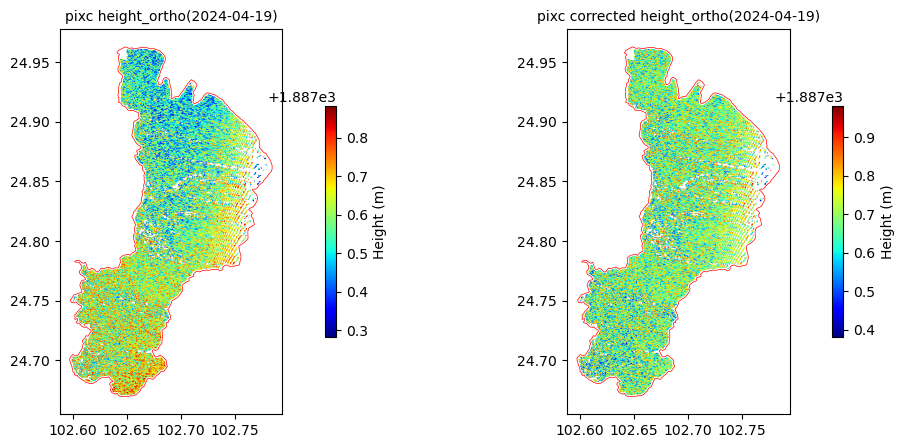

In [12]:
ht_ortho_mean = np.nanmean(pixc_height_xr.ht_ortho.values)
ht_ortho_cor_mean = np.nanmean(pixc_height_xr.ht_ortho_cor.values)

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
## ax0
scat = ax[0].scatter(x= pixc_height_xr.longitude, y=pixc_height_xr.latitude, 
                      c=pixc_height_xr.ht_ortho.values,
                      vmin=ht_ortho_mean - 0.3,
                      vmax=ht_ortho_mean + 0.3,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[0], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6, pad=0.1)  
ax[0].set_title('pixc height_ortho' + f'({pixc_height_xr.attrs["date"]})', fontsize=10)
## ax1
scat = ax[1].scatter(x=pixc_height_xr.longitude, y=pixc_height_xr.latitude, 
                      c=pixc_height_xr.ht_ortho_cor.values,
                      vmin=ht_ortho_cor_mean - 0.3,
                      vmax=ht_ortho_cor_mean + 0.3,
                      s=0.5, edgecolor='none', cmap='jet')
lake_gdf.plot(ax=ax[1], color='none', edgecolor='red', linewidth=0.5)
plt.colorbar(scat, label='Height (m)', shrink=0.6, pad=0.1)  
ax[1].set_title('pixc corrected height_ortho' + f'({pixc_height_xr.attrs["date"]})', fontsize=10)


In [21]:
import numpy as np
from math import radians, sin, cos, atan2, degrees

def points_directional_stat(lons, lats, values, num_bins=12, center_lon=None, center_lat=None):
    """
    在极坐标系下统计不同方向上的均值和标准差
    
    参数:
    lons -- 经度数组 (度)
    lats -- 纬度数组 (度)
    values -- 对应点的值数组
    num_bins -- 角度分区数量 (默认36)
    center_lon -- 极坐标系原点经度 (默认数据中心)
    center_lat -- 极坐标系原点纬度 (默认数据中心)
    
    返回:
    包含以下内容的字典:
        bin_centers - 分区中心角度 (度)
        means - 各分区值的平均值
        stds - 各分区值的标准差
    """
    # 转换为numpy数组
    lons = np.asarray(lons)
    lats = np.asarray(lats)
    values = np.asarray(values)
    
    # 检查输入数据有效性
    if len(lons) != len(lats) or len(lons) != len(values):
        raise ValueError("经度、纬度和值数组长度必须一致")
    
    if num_bins < 4:
        raise ValueError("分区数量至少为4")
    
    # 设置极坐标系原点
    if center_lon is None:
        center_lon = np.nanmean(lons)
    if center_lat is None:
        center_lat = np.nanmean(lats)

    # 将中心点转换为弧度
    center_lon_rad = radians(center_lon)
    center_lat_rad = radians(center_lat)
    
    # 计算每个点相对于原点的角度
    angles = []
    
    # 地球半径 (米)
    R = 6371000  # 平均地球半径
    
    for lon, lat in zip(lons, lats):
        # 转换为弧度
        lon_rad = radians(lon)
        lat_rad = radians(lat)
        
        # 计算角度 (从正北方向顺时针0-360度)
        dlon = lon_rad - center_lon_rad
        y = sin(dlon) * cos(lat_rad)
        x = cos(center_lat_rad) * sin(lat_rad) - sin(center_lat_rad) * cos(lat_rad) * cos(dlon)
        angle_rad = atan2(y, x)
        angle_deg = (degrees(angle_rad) + 360) % 360  # 转换为0-360度
        angles.append(angle_deg)
    
    angles = np.array(angles)
    
    # 创建角度分区边界
    bin_edges = np.linspace(0, 360, num_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # 初始化统计存储
    means = np.full(num_bins, np.nan)
    stds = np.full(num_bins, np.nan)
    
    # 计算每个方向的统计量
    for i in range(num_bins):
        # 获取当前方向分区内的点
        # 处理0度和360度边界
        if i == num_bins - 1:
            mask = (angles >= bin_edges[i]) | (angles < bin_edges[i+1])
        else:
            mask = (angles >= bin_edges[i]) & (angles < bin_edges[i+1])
        
        bin_values = values[mask]
        
        if len(bin_values) > 1:
            means[i] = np.nanmean(bin_values)
            stds[i] = np.nanstd(bin_values, ddof=1)  # 样本标准差
        elif len(bin_values) == 1:
            means[i] = bin_values[0]
            stds[i] = 0
    
    # 返回结果
    return bin_centers, means, stds


In [25]:
# bin_centers_deg, height_ortho_means, height_ortho_stds = points_directional_stat(
#     pixc_height_xr.longitude.values,
#     pixc_height_xr.latitude.values,
#     pixc_height_xr.ht_ortho.values,
#     num_bins=12
# ) 
# bin_centers_deg, height_ortho_cor_means, height_ortho_cor_stds = points_directional_stat(
#     pixc_height_xr.longitude.values,
#     pixc_height_xr.latitude.values,
#     pixc_height_xr.ht_ortho_cor.values,
#     num_bins=12
# )

Text(0.5, 1.0, 'Corrected orthometric Height')

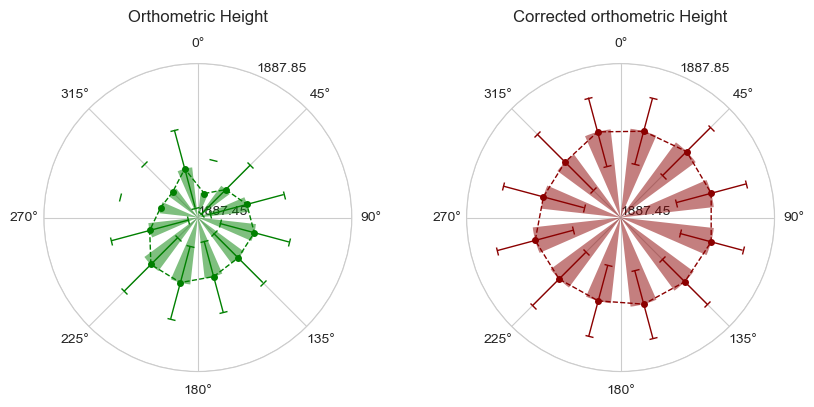

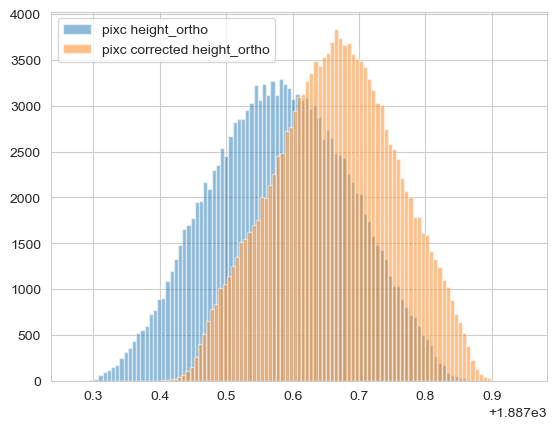

In [26]:
plt.hist(pixc_height_xr.ht_ortho.values, bins=100, 
                        alpha=0.5, label='pixc height_ortho');
plt.hist(pixc_height_xr.ht_ortho_cor.values, bins=100, 
                        alpha=0.5, label='pixc corrected height_ortho');
plt.legend();



#### 2. statistics of the mean orthometric height from different direction. 


In [7]:
xmin, ymin, xmax, ymax = lake_gdf.geometry[0].buffer(0.01).bounds
raster_extent = (xmin, xmax, ymin, ymax)
print('Raster extent:', raster_extent)
lat_center = pixc_height_xr.latitude.mean().values
res_lon, res_lat = meter2deg(meter=200, lat=lat_center)
print('Resolution (lat, lon):', res_lat, res_lon)


Raster extent: (102.58735478065672, 102.7945962055395, 24.659172532594734, 24.973034361471274)
Resolution (lat, lon): 0.0017986432118374611 0.0019818523665410094


In [8]:
height_ortho = pixc2raster(pixc_var = pixc_height_xr.ht_ortho.values, 
                        pixc_lonlat=(pixc_height_xr.longitude.values, pixc_height_xr.latitude.values), 
                        raster_extent=raster_extent,
                        resolution=(res_lon, res_lat))
height_ortho_cor = pixc2raster(pixc_var = pixc_height_xr.ht_ortho_cor.values, 
                        pixc_lonlat=(pixc_height_xr.longitude.values, pixc_height_xr.latitude.values), 
                        raster_extent=raster_extent,
                        resolution=(res_lon, res_lat))


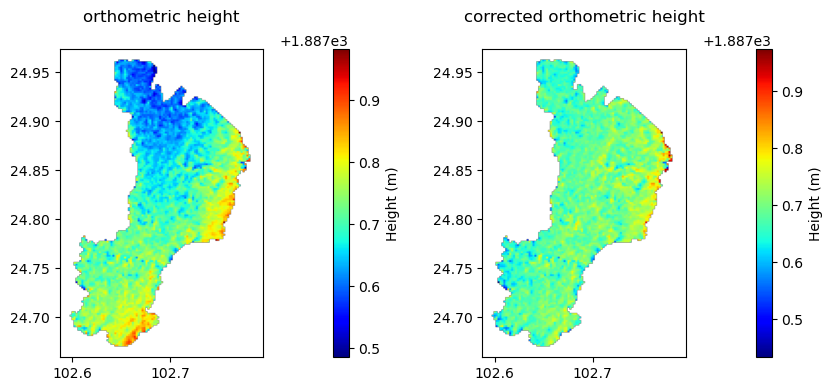

In [9]:
## show the raster data
plt.style.use('default')
fig, ax = plt.subplots(1, 2, figsize=(10, 4))
im1 = ax[0].imshow(height_ortho.values, cmap='jet', extent=raster_extent)
im2 = ax[1].imshow(height_ortho_cor.values, cmap='jet', extent=raster_extent)
ax[0].set_title('orthometric height', pad=20)
ax[1].set_title('corrected orthometric height', pad=20)
plt.colorbar(im1, ax=ax[0], label='Height (m)', pad=0.2)
plt.colorbar(im2, ax=ax[1], label='Height (m)', pad=0.2)


In [12]:
bin_centers_deg, height_ortho_means, height_ortho_stds = raster_directional_stats(raster_data=height_ortho.values, num_bins=12)
bin_centers_deg, height_ortho_cor_means, height_ortho_cor_stds = raster_directional_stats(raster_data=height_ortho_cor.values, num_bins=12)
bin_centers_deg

array([ 15.,  45.,  75., 105., 135., 165., 195., 225., 255., 285., 315.,
       345.])

Text(0.5, 1.0, 'Corrected orthometric Height')

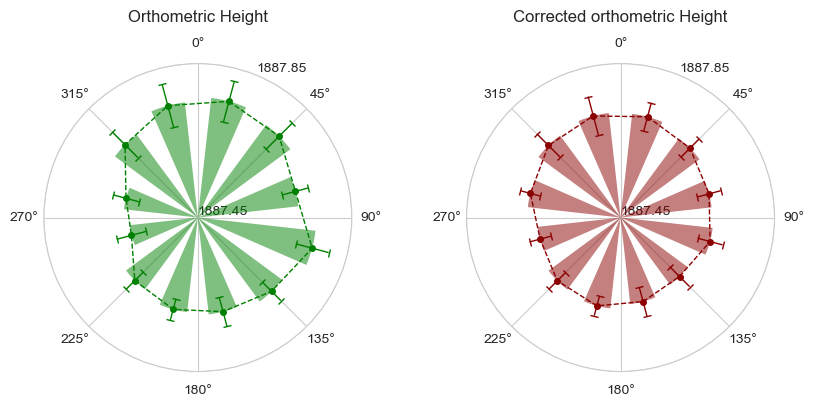

In [11]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(1, 2,  figsize=(10, 4), subplot_kw={'projection': 'polar'})
x_ticks = np.radians(bin_centers_deg)
baseline = 1887.45
range_height = 0.4
ax[0].bar(x=x_ticks, height=height_ortho_means - baseline, 
          width=0.3, color='green', edgecolor='none', alpha=0.5, bottom=baseline)
ax[0].plot(
  np.append(x_ticks, x_ticks[0]),
  np.append(height_ortho_means, height_ortho_means[0]),
  color='green', linewidth=1, linestyle='--', label='Orthometric Height Mean')

ax[0].errorbar(x=x_ticks, y=height_ortho_means, 
                  yerr=height_ortho_stds, fmt='o', color='green', 
                  capsize=3, elinewidth=1, markersize=4)
ax[0].set_ylim(baseline, baseline + range_height)
ax[0].set_yticks([baseline, baseline + range_height])
ax[0].set_yticklabels([f"{baseline:.2f}", f"{(baseline + range_height):.2f}"])
ax[0].set_theta_zero_location('N')  
ax[0].set_theta_direction(-1)
ax[0].set_title('Orthometric Height', pad=30)

ax[1].bar(x=x_ticks, height=height_ortho_cor_means - baseline, 
          width=0.3, color='darkred', edgecolor='none', alpha=0.5, bottom=baseline)
ax[1].errorbar(x=x_ticks, y=height_ortho_cor_means, 
                  yerr=height_ortho_cor_stds, fmt='o', color='darkred', 
                  capsize=3, elinewidth=1, markersize=4)
ax[1].plot(
  np.append(x_ticks, x_ticks[0]),
  np.append(height_ortho_cor_means, height_ortho_cor_means[0]),
  color='darkred', linewidth=1, linestyle='--', label='Corrected Orthometric Height Mean')

ax[1].set_ylim(baseline, baseline + range_height)
ax[1].set_yticks([baseline, baseline + range_height])
ax[1].set_yticklabels([f"{baseline:.2f}", f"{(baseline + range_height):.2f}"])
ax[1].set_theta_zero_location('N')  
ax[1].set_theta_direction(-1)
ax[1].set_title('Corrected orthometric Height', pad=30)
